# Predict the level of Problematic Internet Use Among Children and Adolescents

### Import Libraries and Dataset

In [66]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
import math

In [67]:
# file paths
filePathTrain = r'D:\7th Semester\Data Mining\Mini-project\Dataset\train.csv'
filePathTest = r'D:\7th Semester\Data Mining\Mini-project\Dataset\test.csv'
filePathDict = r'D:\7th Semester\Data Mining\Mini-project\Dataset\data_dictionary.csv'

# Load data into data frames
train_data = pd.read_csv(filePathTrain)
test_data = pd.read_csv(filePathTest)
data_dictionary = pd.read_csv(filePathDict)

## 1. Introduction

*The primary objective of this project is to utilize our training data to predict the Severity Impairment Index (SII), a standardized metric used to assess the level of Problematic Internet Use (PIU).*

In [68]:
print(f"The shape of the training DataFrame       : {train_data.shape}")
print(f"The shape of the test DataFrame           : {test_data.shape}")
print(f"The shape of the data dictionary DataFrame: {data_dictionary.shape}")

The shape of the training DataFrame       : (3960, 82)
The shape of the test DataFrame           : (20, 59)
The shape of the data dictionary DataFrame: (81, 6)


In [69]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 82 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      3960 non-null   object 
 1   Basic_Demos-Enroll_Season               3960 non-null   object 
 2   Basic_Demos-Age                         3960 non-null   int64  
 3   Basic_Demos-Sex                         3960 non-null   int64  
 4   CGAS-Season                             2555 non-null   object 
 5   CGAS-CGAS_Score                         2421 non-null   float64
 6   Physical-Season                         3310 non-null   object 
 7   Physical-BMI                            3022 non-null   float64
 8   Physical-Height                         3027 non-null   float64
 9   Physical-Weight                         3076 non-null   float64
 10  Physical-Waist_Circumference            898 non-null    floa

> The training dataset includes 3,960 records of children and adolescents, each with 81 features (excluding the ID column). Among the critical fields is the Parent-Child Internet Addiction Test (PCIAT) results. The target variable is derived from the `PCIAT_Total` field, scored out of 100.

> This setup provides two modeling options: we can predict the PCIAT Total directly and then convert it to the `Severity Impairment Index (SII)`, framing the task as a ***regression problem***, or we can focus on predicting the SII itself, framing it as a ***classification problem***.

In [70]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 59 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      20 non-null     object 
 1   Basic_Demos-Enroll_Season               20 non-null     object 
 2   Basic_Demos-Age                         20 non-null     int64  
 3   Basic_Demos-Sex                         20 non-null     int64  
 4   CGAS-Season                             10 non-null     object 
 5   CGAS-CGAS_Score                         8 non-null      float64
 6   Physical-Season                         14 non-null     object 
 7   Physical-BMI                            13 non-null     float64
 8   Physical-Height                         13 non-null     float64
 9   Physical-Weight                         13 non-null     float64
 10  Physical-Waist_Circumference            5 non-null      float64


> In the test dataset, none of the 22 PCIAT-related fields are available, including the target feature, resulting in a sample format with only **58 columns** compared to the 81 columns in the training data. Additionally, the test dataset contains only **20 samples**.

In [71]:
print("Total number of missing training values: ", train_data.isna().sum().sum())

Total number of missing training values:  131717


## 2. Features
---

**Measurements from a variety of instruments**

1. **Demographics**: Information about the age and sex of participants.

2. **Internet Use**: The number of hours participants spend using a computer or the internet per day.

3. **Children's Global Assessment Scale**: A numeric scale used by mental health clinicians to assess the general functioning of youths under the age of 18.

4. **Physical Measures**: Data on participants' `blood pressure`, `heart rate`, `height`, `weight`, and `waist and hip measurements`.

5. **FitnessGram Vitals and Treadmill**: Measurements of cardiovascular fitness assessed using the NHANES treadmill protocol.

6. **FitnessGram Child**: A health-related physical fitness assessment measuring five parameters: `aerobic capacity`, `muscular strength`, `muscular endurance`, `flexibility`, and `body composition`.

7. **Bio-electric Impedance Analysis**: A measure of key body composition elements, including `BMI`, `fat percentage`, `muscle mass`, and `water content`.

8. **Physical Activity Questionnaire**: Information about children's participation in vigorous physical activities over the past 7 days.

9. **Sleep Disturbance Scale**: A scale used to categorize sleep disorders in children.

10. **Actigraphy**: An objective measure of ecological physical activity collected using a research-grade biotracker.

11. **Parent-Child Internet Addiction Test (PCIAT)**: A 20-item scale measuring characteristics and behaviors associated with compulsive internet use, including compulsivity, escapism, and dependency.

    **PCIAT_Total**: This field summarizes the results of the PCIAT test. The target variable, `SII`, is derived from this field, with categories as follows: 
    - 0: None
    - 1: Mild
    - 2: Moderate
    - 3: Severe

12. **Participant Identifier**: Each participant is assigned a unique identifier (`id`).

>**Season**: *For each set of measurements, there is a 'season' feature indicating the season of the year when the measurements were carried out. This is one of the primary categorical features in the dataset and can be easily preprocessed.*

In [72]:
data_dictionary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Instrument    81 non-null     object
 1   Field         81 non-null     object
 2   Description   81 non-null     object
 3   Type          81 non-null     object
 4   Values        42 non-null     object
 5   Value Labels  32 non-null     object
dtypes: object(6)
memory usage: 3.9+ KB


In [73]:
unique_instruments = data_dictionary['Instrument'].unique()
unique_instruments

array(['Identifier', 'Demographics', "Children's Global Assessment Scale",
       'Physical Measures', 'FitnessGram Vitals and Treadmill',
       'FitnessGram Child', 'Bio-electric Impedance Analysis',
       'Physical Activity Questionnaire (Adolescents)',
       'Physical Activity Questionnaire (Children)',
       'Parent-Child Internet Addiction Test', 'Sleep Disturbance Scale',
       'Internet Use'], dtype=object)

In [85]:
def plot_demographic_features(data, features, title):
    """
    Generate plots for demographic features based on their type.
    
    Parameters:
    - data: pd.DataFrame, the dataset containing demographic features
    - features: dict, a dictionary where keys are feature names and values are types ('categorical', 'numerical', 'binary')
    """
    # Determine layout based on the number of features
    num_features = len(features)
    cols = 3  # Set a fixed number of columns
    rows = math.ceil(num_features / cols)  # Calculate required rows
    
    plt.figure(figsize=(6 * cols, 5 * rows))  # Adjust figure size based on rows and columns
    plt.suptitle(f'Visualizations of {title} Features', fontsize=16)

    for i, (feature, ftype) in enumerate(features.items(), 1):
        plt.subplot(rows, cols, i)
        
        if ftype == 'categorical' or ftype == 'binary':
            sns.countplot(data=data, x=feature, palette='viridis' if ftype == 'categorical' else 'pastel')
            plt.xlabel(feature.replace('_', ' '))
            plt.ylabel('Count')
        elif ftype == 'numerical':
            sns.histplot(data[feature], bins=10, kde=True, color='skyblue')
            plt.xlabel(feature.replace('_', ' '))
            plt.ylabel('Frequency')
        
        plt.title(f'Distribution of {feature.replace("_", " ")}')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

### Handling season feature in every measurement

In [75]:
train_cat_columns = train_data.select_dtypes(exclude = 'number').columns

for season in train_cat_columns:
    train_data[season] = train_data[season].fillna(0)
    train_data[season] = train_data[season].replace({'Spring':1, 'Summer':2, 'Fall':3, 'Winter':4})

### 1. PCIAT Features

As noted, the 22 PCIAT features consist of responses to 20 questions (each scored out of 5), along with the total PCIAT score and the "season" in which the test was conducted. The SII target is derived from the total PCIAT score based on the following scale:

- 0–30: SII = 0
- 31–49: SII = 1
- 50–79: SII = 2
- 80–100: SII = 3

In [76]:
print(f"Samples for Instrument: {unique_instruments[9]}")
display(data_dictionary[data_dictionary['Instrument'] == unique_instruments[9]])

Samples for Instrument: Parent-Child Internet Addiction Test


,Instrument,Field,Description,Type,Values,Value Labels
54,Parent-Child Internet Addiction Test,PCIAT-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
55,Parent-Child Internet Addiction Test,PCIAT-PCIAT_01,How often does your child disobey time limits ...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
56,Parent-Child Internet Addiction Test,PCIAT-PCIAT_02,How often does your child neglect household ch...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
57,Parent-Child Internet Addiction Test,PCIAT-PCIAT_03,How often does your child prefer to spend time...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
58,Parent-Child Internet Addiction Test,PCIAT-PCIAT_04,How often does your child form new relationshi...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
59,Parent-Child Internet Addiction Test,PCIAT-PCIAT_05,How often do you complain about the amount of ...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
60,Parent-Child Internet Addiction Test,PCIAT-PCIAT_06,How often do your child's grades suffer becaus...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
61,Parent-Child Internet Addiction Test,PCIAT-PCIAT_07,How often does your child check his or her e-m...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
62,Parent-Child Internet Addiction Test,PCIAT-PCIAT_08,How often does your child seem withdrawn from ...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
63,Parent-Child Internet Addiction Test,PCIAT-PCIAT_09,How often does your child become defensive or ...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."


In [77]:
PCIAT_cols = [val for val in train_data.columns[train_data.columns.str.contains('PCIAT')]]
print('Number of PCIAT features = ' , len(PCIAT_cols))

Number of PCIAT features =  22


In [78]:
fig = px.scatter(train_data, x = 'PCIAT-PCIAT_Total', color = 'sii', marginal_x="box", title = 'PCIAT Total')
fig = fig.update_layout(yaxis_title="")
fig.update_yaxes(showticklabels=False)


> `The box plot visualization of the PCIAT Total scores reveals that many of the higher scores appear as outliers.`



In [79]:
print(train_data[train_data['PCIAT-PCIAT_Total']<=30].sii.value_counts())
print(train_data[(train_data['PCIAT-PCIAT_Total']>30)
    & (train_data['PCIAT-PCIAT_Total']<50)].sii.value_counts())
print(train_data[(train_data['PCIAT-PCIAT_Total']>=50)
    & (train_data['PCIAT-PCIAT_Total']<80)].sii.value_counts())
print(train_data[train_data['PCIAT-PCIAT_Total']>=80].sii.value_counts())
print(train_data.sii.value_counts())
print('\n')
# Check if sii values are consistent within each PCIAT_Total score range
is_consistent = (
    (train_data[train_data['PCIAT-PCIAT_Total'] <= 30]['sii'] == 0).all() and
    (train_data[(train_data['PCIAT-PCIAT_Total'] > 30) & (train_data['PCIAT-PCIAT_Total'] < 50)]['sii'] == 1).all() and
    (train_data[(train_data['PCIAT-PCIAT_Total'] >= 50) & (train_data['PCIAT-PCIAT_Total'] < 80)]['sii'] == 2).all() and
    (train_data[train_data['PCIAT-PCIAT_Total'] >= 80]['sii'] == 3).all()
)

print("SII distribution is consistent with PCIAT_Total score ranges:", is_consistent)

sii
0.0    1594
Name: count, dtype: int64
sii
1.0    730
Name: count, dtype: int64
sii
2.0    378
Name: count, dtype: int64
sii
3.0    34
Name: count, dtype: int64
sii
0.0    1594
1.0     730
2.0     378
3.0      34
Name: count, dtype: int64


SII distribution is consistent with PCIAT_Total score ranges: True


>This sii values are correctly distributed within the PCIAT-PCIAT_Total score intervals.

In [80]:
has_nulls = train_data['sii'].isnull().any()
print("Does the 'sii' column contain null values?", has_nulls)

if has_nulls:
    null_count = train_data['sii'].isnull().sum()
    print("Number of null values in the 'sii' column:", null_count)

train_data[train_data['sii'].isnull()]

Does the 'sii' column contain null values? True
Number of null values in the 'sii' column: 1224


,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
4,0016bb22,1,18,1,2,NaN,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,NaN
7,0068a485,3,10,1,0,NaN,3,16.861286,59.25,84.2,...,NaN,NaN,NaN,NaN,0,NaN,NaN,3,2.0,NaN
8,0069fbed,2,15,0,0,NaN,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,NaN,NaN,2,2.0,NaN
9,0083e397,2,19,1,2,NaN,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,NaN
10,0087dd65,1,11,1,0,NaN,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,NaN,NaN,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3943,fe7c87e2,1,13,0,2,NaN,2,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,NaN
3944,fe7f68a7,1,15,1,0,NaN,1,22.457960,62.00,122.8,...,NaN,NaN,NaN,NaN,1,49.0,68.0,1,2.0,NaN
3950,ff0ab367,1,9,0,0,NaN,1,20.200490,52.50,79.2,...,NaN,NaN,NaN,NaN,0,NaN,NaN,1,0.0,NaN
3956,ffa9794a,4,10,0,0,NaN,1,18.764678,53.50,76.4,...,NaN,NaN,NaN,NaN,0,NaN,NaN,4,0.0,NaN


*Removes any rows in the train DataFrame where the sii column has missing (NaN) values.*

In [82]:
train_data = train_data.dropna(subset='sii')

c:\Users\Hp\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



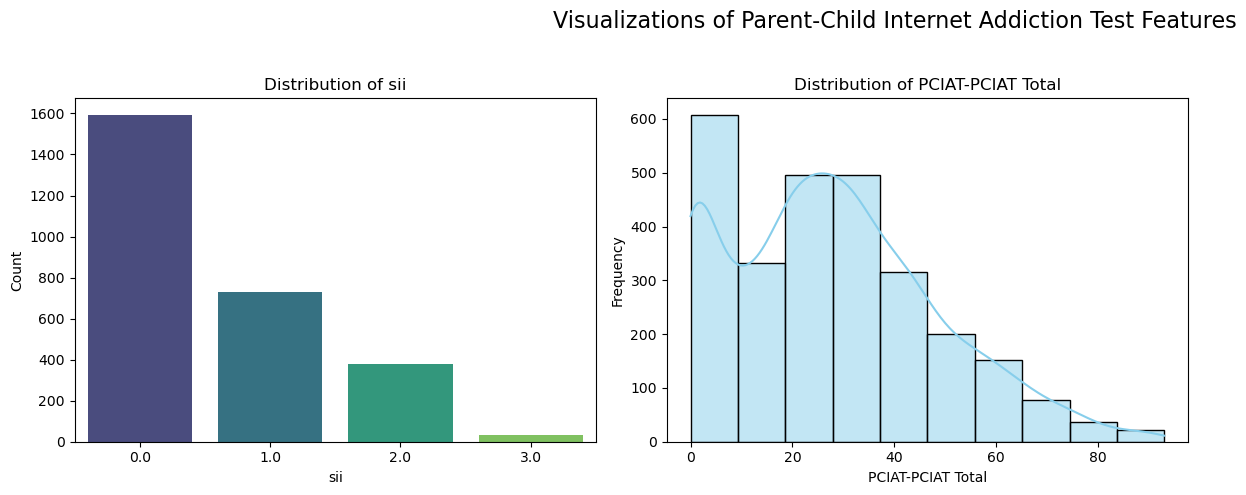

In [86]:
pciat_features = {
    'sii': 'categorical',
    'PCIAT-PCIAT_Total': 'numerical',
}

plot_demographic_features(train_data, pciat_features, 'Parent-Child Internet Addiction Test')


>`The visualization of the sii feature reveals an imbalance across its categories. Category 0 has the largest number of samples, while categories 1 and 2 have fewer samples in comparison. Category 3 contains only a small number of samples, indicating a significant skew in the data distribution across these categories.`

*For analysis, I have decided to drop all individual PCIAT features from the dataset, except for the PCIAT Total score, which will be used as a regression target.*

In [16]:
PCIAT_cols.remove('PCIAT-PCIAT_Total')
train_data = train_data.drop(columns = PCIAT_cols)

### 2. Demographics Features

In [17]:
print(f"Samples for Instrument: {unique_instruments[1]}")
display(data_dictionary[data_dictionary['Instrument'] == unique_instruments[1]])

Samples for Instrument: Demographics


,Instrument,Field,Description,Type,Values,Value Labels
1,Demographics,Basic_Demos-Enroll_Season,Season of enrollment,str,"Spring, Summer, Fall, Winter",NaN
2,Demographics,Basic_Demos-Age,Age of participant,float,NaN,NaN
3,Demographics,Basic_Demos-Sex,Sex of participant,categorical int,"0,1","0=Male, 1=Female"


c:\Users\Hp\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



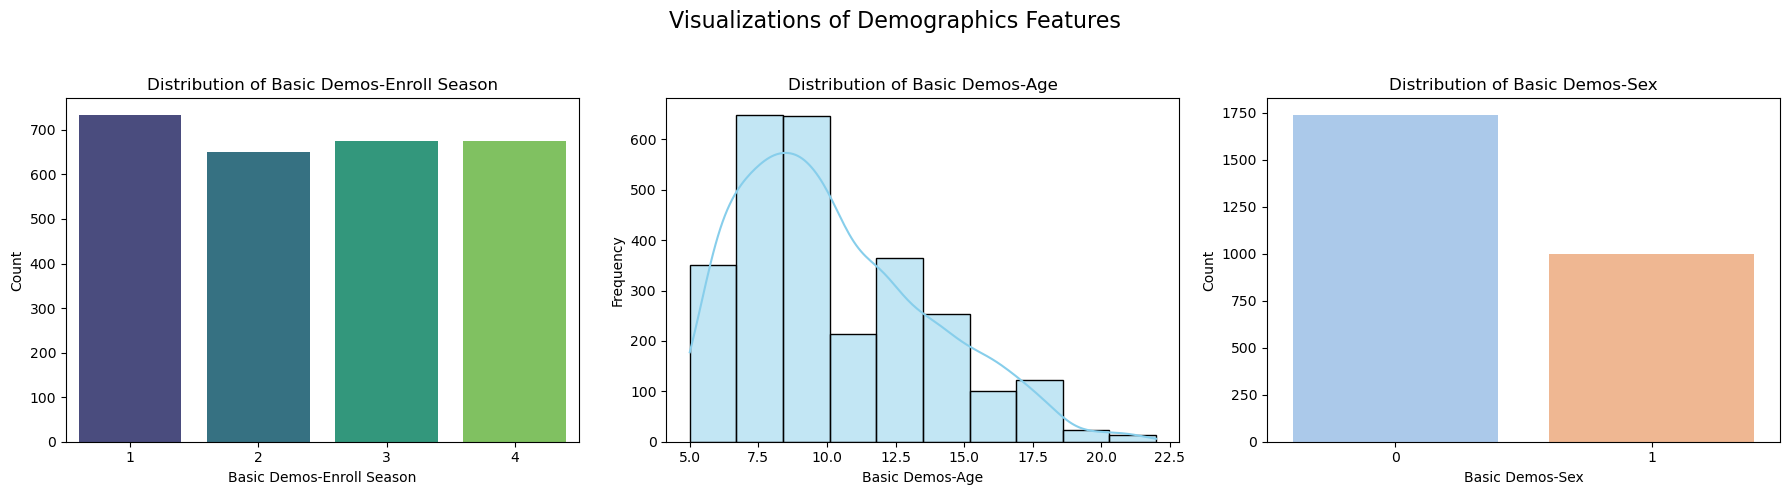

In [87]:
demographics_features = {
    'Basic_Demos-Enroll_Season': 'categorical',
    'Basic_Demos-Age': 'numerical',
    'Basic_Demos-Sex': 'binary'
}

plot_demographic_features(train_data, demographics_features, 'Demographics')


### 3. Internet Use

In [20]:
print(f"Samples for Instrument: {unique_instruments[11]}")
display(data_dictionary[data_dictionary['Instrument'] == unique_instruments[11]])

Samples for Instrument: Internet Use


,Instrument,Field,Description,Type,Values,Value Labels
79,Internet Use,PreInt_EduHx-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
80,Internet Use,PreInt_EduHx-computerinternet_hoursday,Hours of using computer/internet,categorical int,"0,1,2,3","0=Less than 1h/day, 1=Around 1h/day, 2=Around ..."


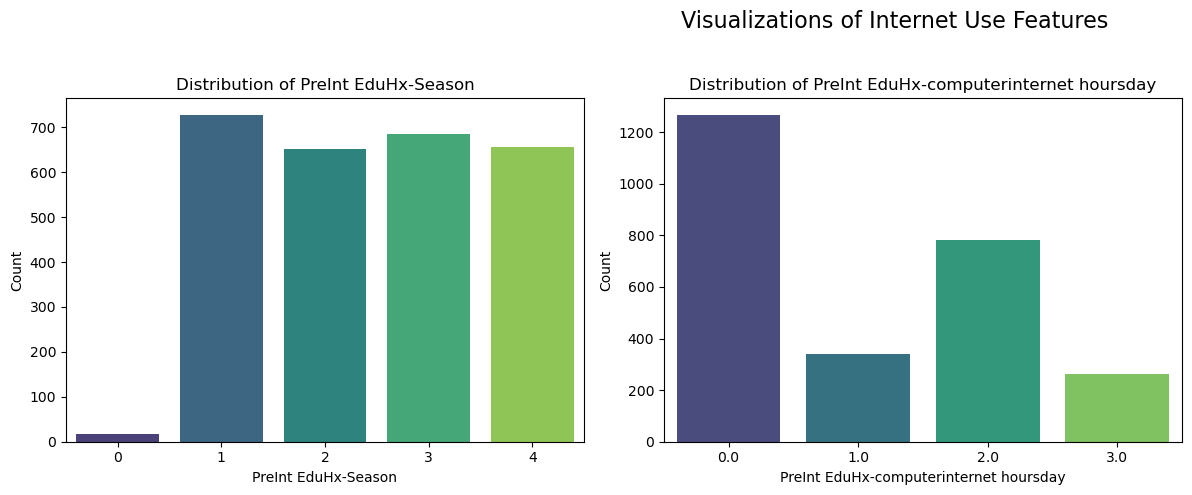

In [88]:
internetUse_features = {
    'PreInt_EduHx-Season': 'categorical',
    'PreInt_EduHx-computerinternet_hoursday': 'categorical'
}

plot_demographic_features(train_data, internetUse_features, 'Internet Use')


### 4. Children's Global Assessment Scale

In [22]:
print(f"Samples for Instrument: {unique_instruments[2]}")
display(data_dictionary[data_dictionary['Instrument'] == unique_instruments[2]])

Samples for Instrument: Children's Global Assessment Scale


,Instrument,Field,Description,Type,Values,Value Labels
4,Children's Global Assessment Scale,CGAS-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
5,Children's Global Assessment Scale,CGAS-CGAS_Score,Children's Global Assessment Scale Score,int,NaN,NaN


c:\Users\Hp\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



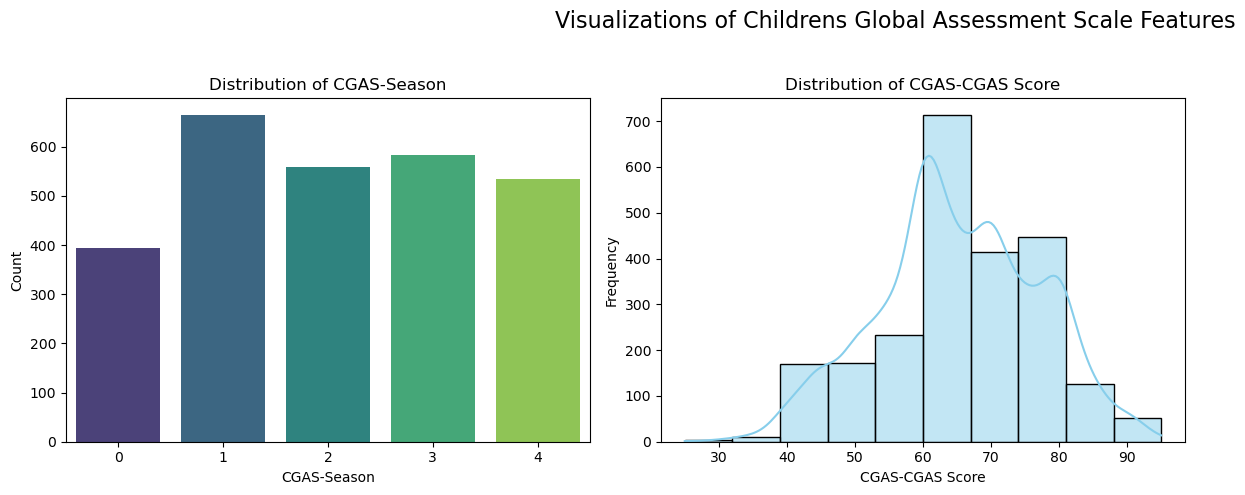

In [90]:
childrenGlobalAssessmentScale_features = {
    'CGAS-Season': 'categorical',
    'CGAS-CGAS_Score': 'numerical'
}

plot_demographic_features(train_data, childrenGlobalAssessmentScale_features, 'Childrens Global Assessment Scale')


### 5. Physical Measures

In [29]:
print(f"Samples for Instrument: {unique_instruments[3]}")
display(data_dictionary[data_dictionary['Instrument'] == unique_instruments[3]])

Samples for Instrument: Physical Measures


,Instrument,Field,Description,Type,Values,Value Labels
6,Physical Measures,Physical-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
7,Physical Measures,Physical-BMI,Body Mass Index (kg/m^2),float,NaN,NaN
8,Physical Measures,Physical-Height,Height (in),float,NaN,NaN
9,Physical Measures,Physical-Weight,Weight (lbs),float,NaN,NaN
10,Physical Measures,Physical-Waist_Circumference,Waist circumference (in),int,NaN,NaN
11,Physical Measures,Physical-Diastolic_BP,Diastolic BP (mmHg),int,NaN,NaN
12,Physical Measures,Physical-HeartRate,Heart rate (beats/min),int,NaN,NaN
13,Physical Measures,Physical-Systolic_BP,Systolic BP (mmHg),int,NaN,NaN


c:\Users\Hp\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\Hp\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\Hp\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\Hp\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\Hp\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version

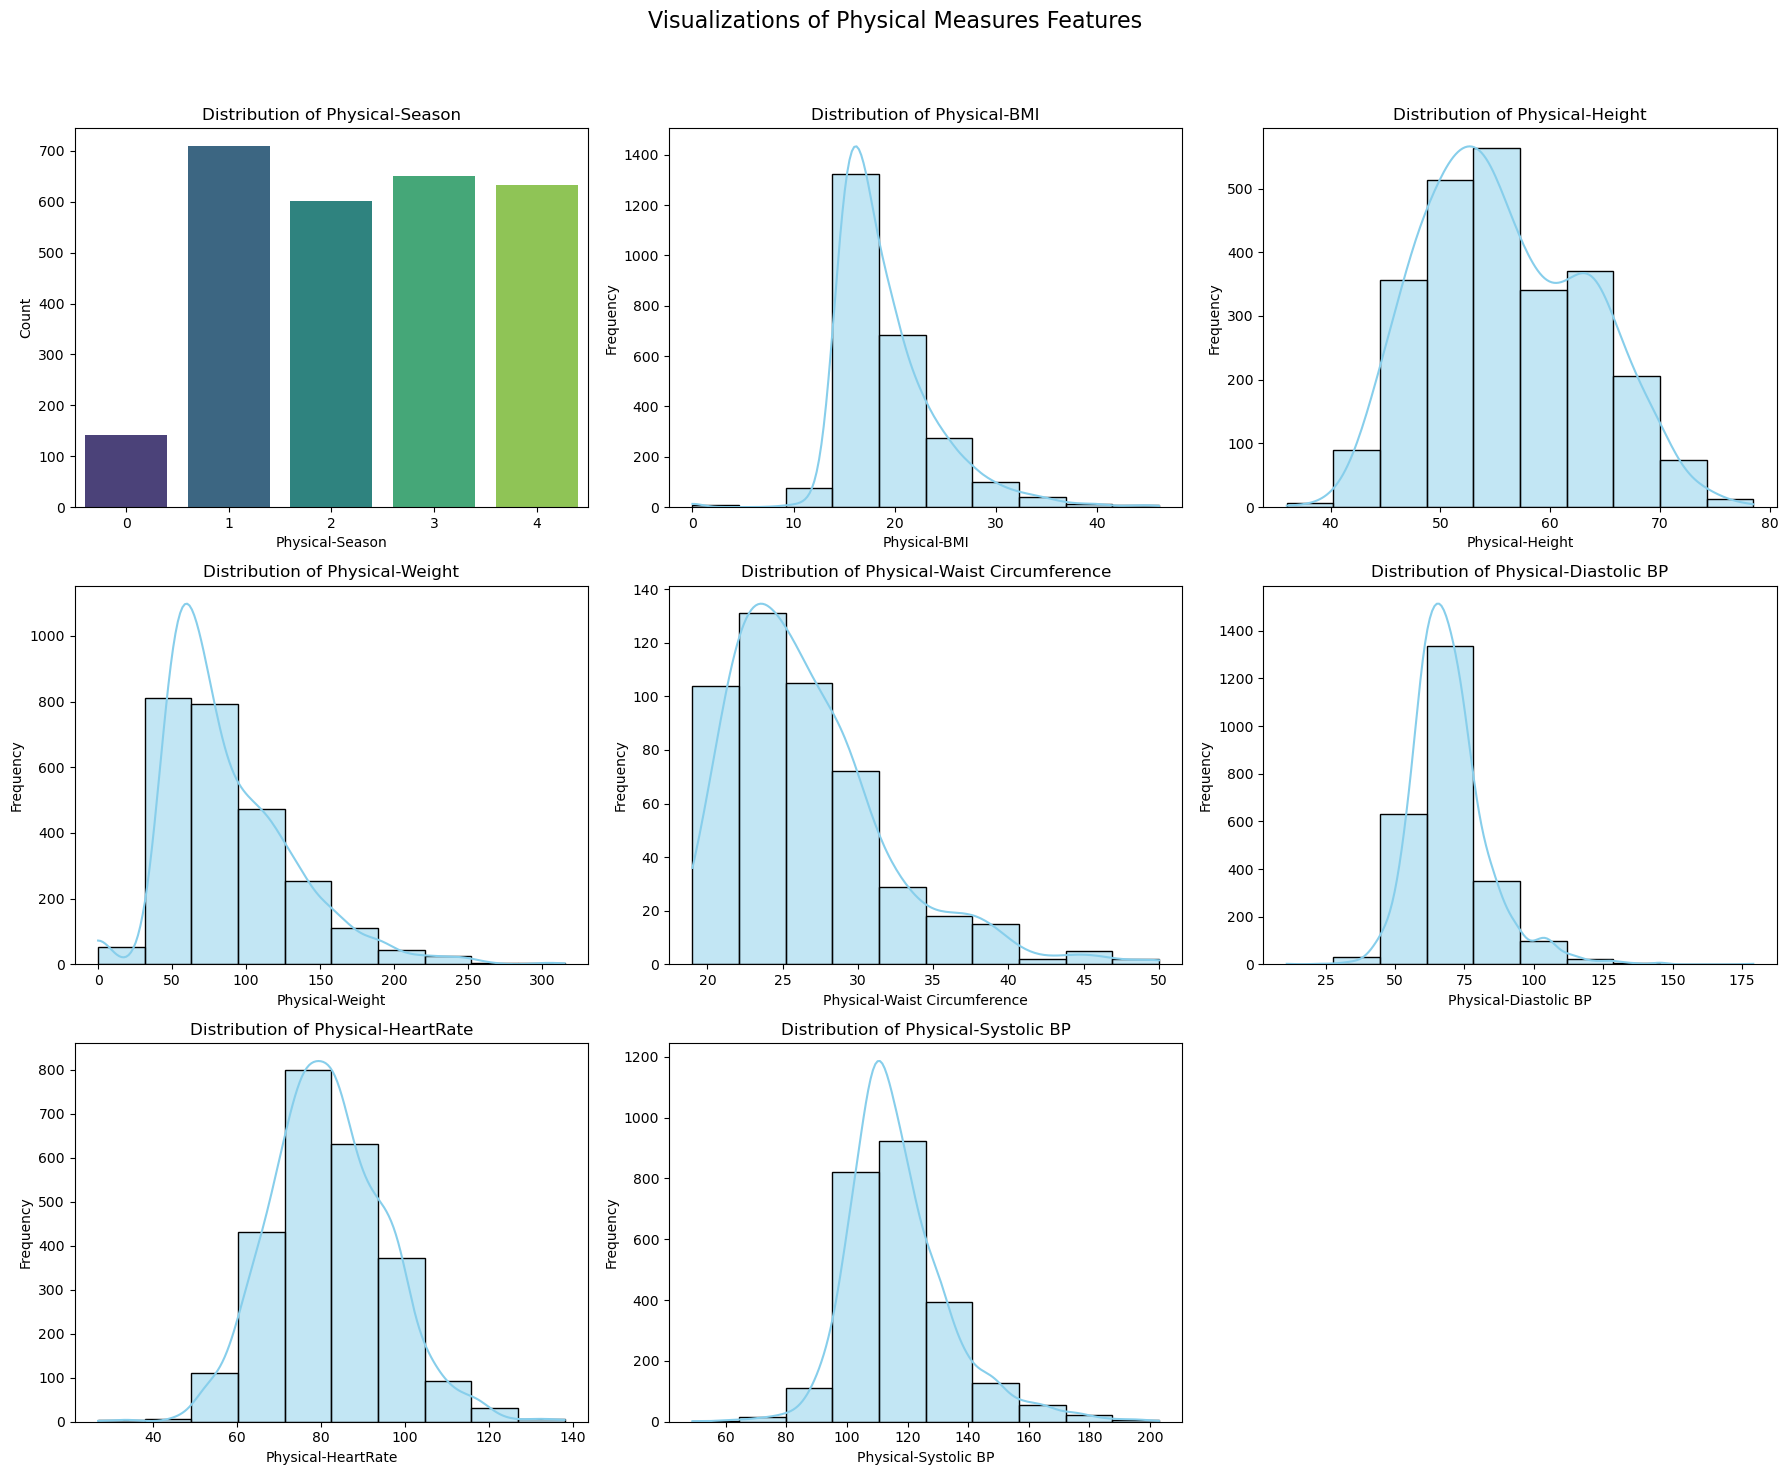

In [91]:
# Example usage
physicalMeasures_features = {
    'Physical-Season': 'categorical',
    'Physical-BMI': 'numerical',
    'Physical-Height': 'numerical',
    'Physical-Weight': 'numerical',
    'Physical-Waist_Circumference': 'numerical',
    'Physical-Diastolic_BP': 'numerical',
    'Physical-HeartRate': 'numerical',
    'Physical-Systolic_BP': 'numerical',
}

plot_demographic_features(train_data, physicalMeasures_features, 'Physical Measures')


### 6. FitnessGram Vitals and Treadmill

In [31]:
print(f"Samples for Instrument: {unique_instruments[4]}")
display(data_dictionary[data_dictionary['Instrument'] == unique_instruments[4]])

Samples for Instrument: FitnessGram Vitals and Treadmill


,Instrument,Field,Description,Type,Values,Value Labels
14,FitnessGram Vitals and Treadmill,Fitness_Endurance-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
15,FitnessGram Vitals and Treadmill,Fitness_Endurance-Max_Stage,Maximum stage reached,int,NaN,NaN
16,FitnessGram Vitals and Treadmill,Fitness_Endurance-Time_Mins,Exact time completed: Minutes,int,NaN,NaN
17,FitnessGram Vitals and Treadmill,Fitness_Endurance-Time_Sec,Exact time completed: Seconds,int,NaN,NaN


c:\Users\Hp\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\Hp\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\Hp\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



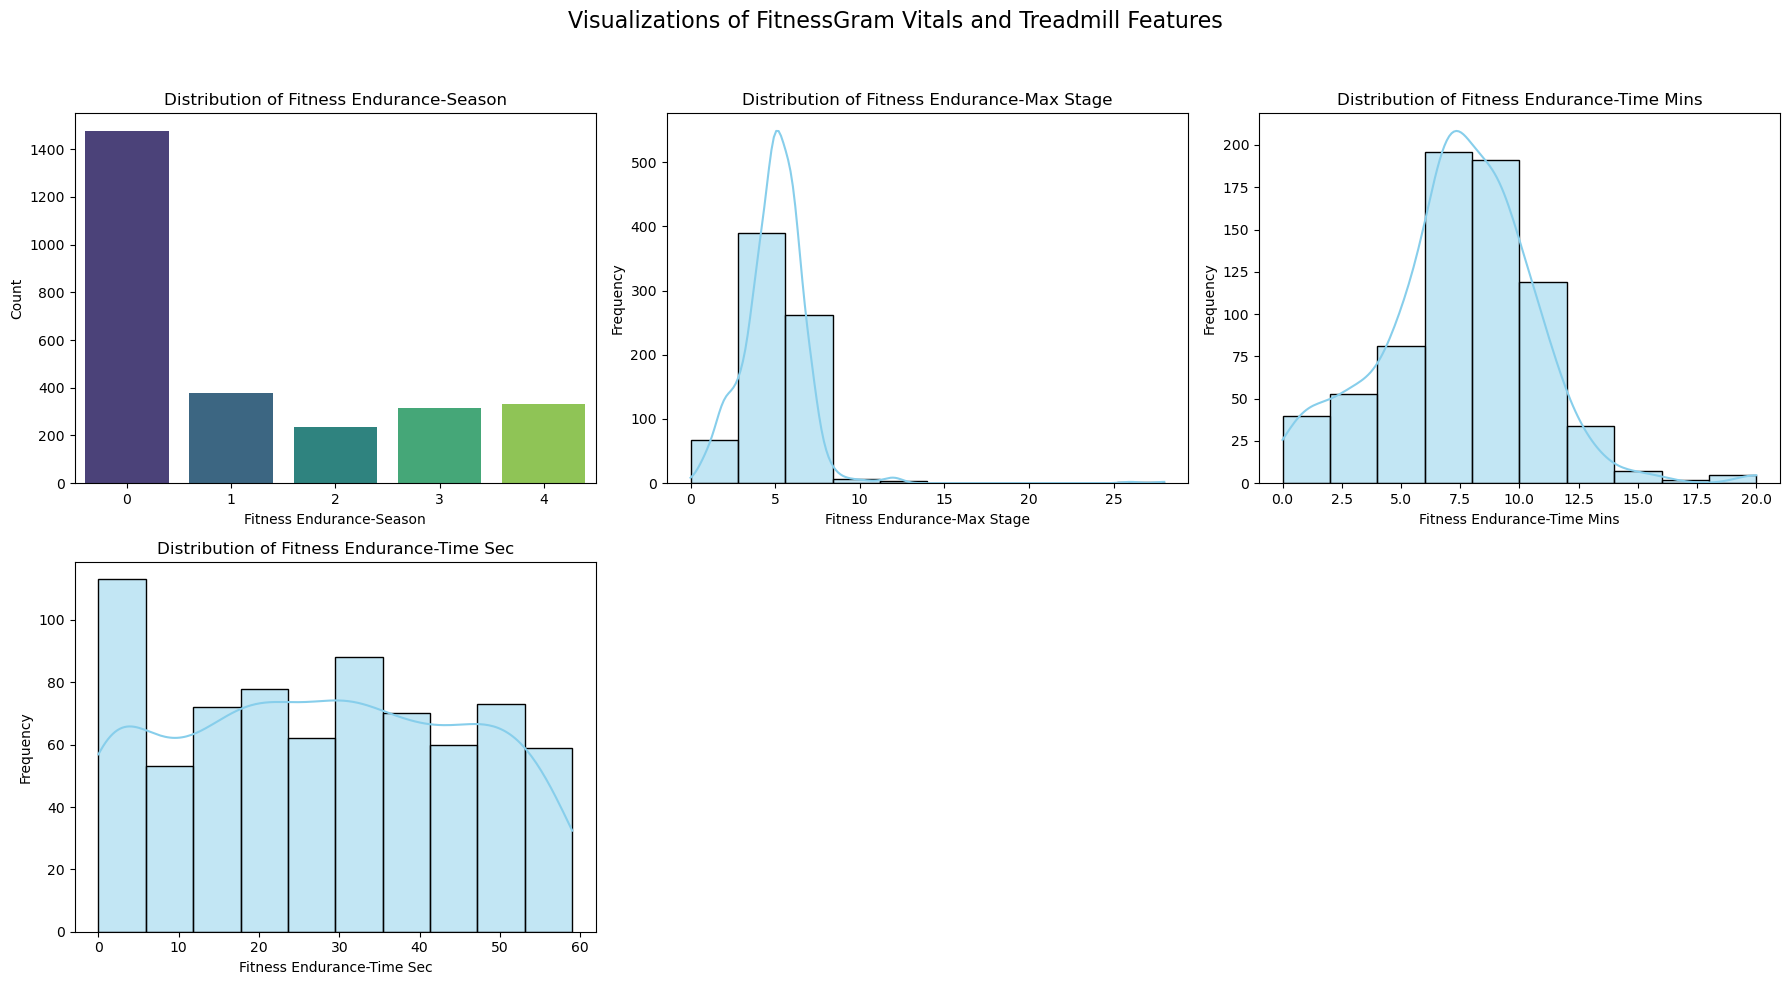

In [92]:
fitnessGramVitalsAndTreadmill_features = {
    'Fitness_Endurance-Season': 'categorical',
    'Fitness_Endurance-Max_Stage': 'numerical',
    'Fitness_Endurance-Time_Mins': 'numerical',
    'Fitness_Endurance-Time_Sec': 'numerical'
}

plot_demographic_features(train_data, fitnessGramVitalsAndTreadmill_features, 'FitnessGram Vitals and Treadmill')


### 7. FitnessGram Child

In [39]:
print(f"Samples for Instrument: {unique_instruments[5]}")
display(data_dictionary[data_dictionary['Instrument'] == unique_instruments[5]])

Samples for Instrument: FitnessGram Child


,Instrument,Field,Description,Type,Values,Value Labels
18,FitnessGram Child,FGC-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
19,FitnessGram Child,FGC-FGC_CU,Curl up total,int,NaN,NaN
20,FitnessGram Child,FGC-FGC_CU_Zone,Curl up fitness zone,categorical int,"0,1","0=Needs Improvement, 1=Healthy Fitness Zone"
21,FitnessGram Child,FGC-FGC_GSND,Grip Strength total (non-dominant),float,NaN,NaN
22,FitnessGram Child,FGC-FGC_GSND_Zone,Grip Strength fitness zone (non-dominant),categorical int,"1,2,3","1=Weak, 2=Normal, 3=Strong"
23,FitnessGram Child,FGC-FGC_GSD,Grip Strength total (dominant),float,NaN,NaN
24,FitnessGram Child,FGC-FGC_GSD_Zone,Grip Strength fitness zone (dominant),categorical int,"1,2,3","1=Weak, 2=Normal, 3=Strong"
25,FitnessGram Child,FGC-FGC_PU,Push-up total,int,NaN,NaN
26,FitnessGram Child,FGC-FGC_PU_Zone,Push-up fitness zone,categorical int,"0,1","0=Needs Improvement, 1=Healthy Fitness Zone"
27,FitnessGram Child,FGC-FGC_SRL,Sit & Reach total (left side),float,NaN,NaN


c:\Users\Hp\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\Hp\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\Hp\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\Hp\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\Hp\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version

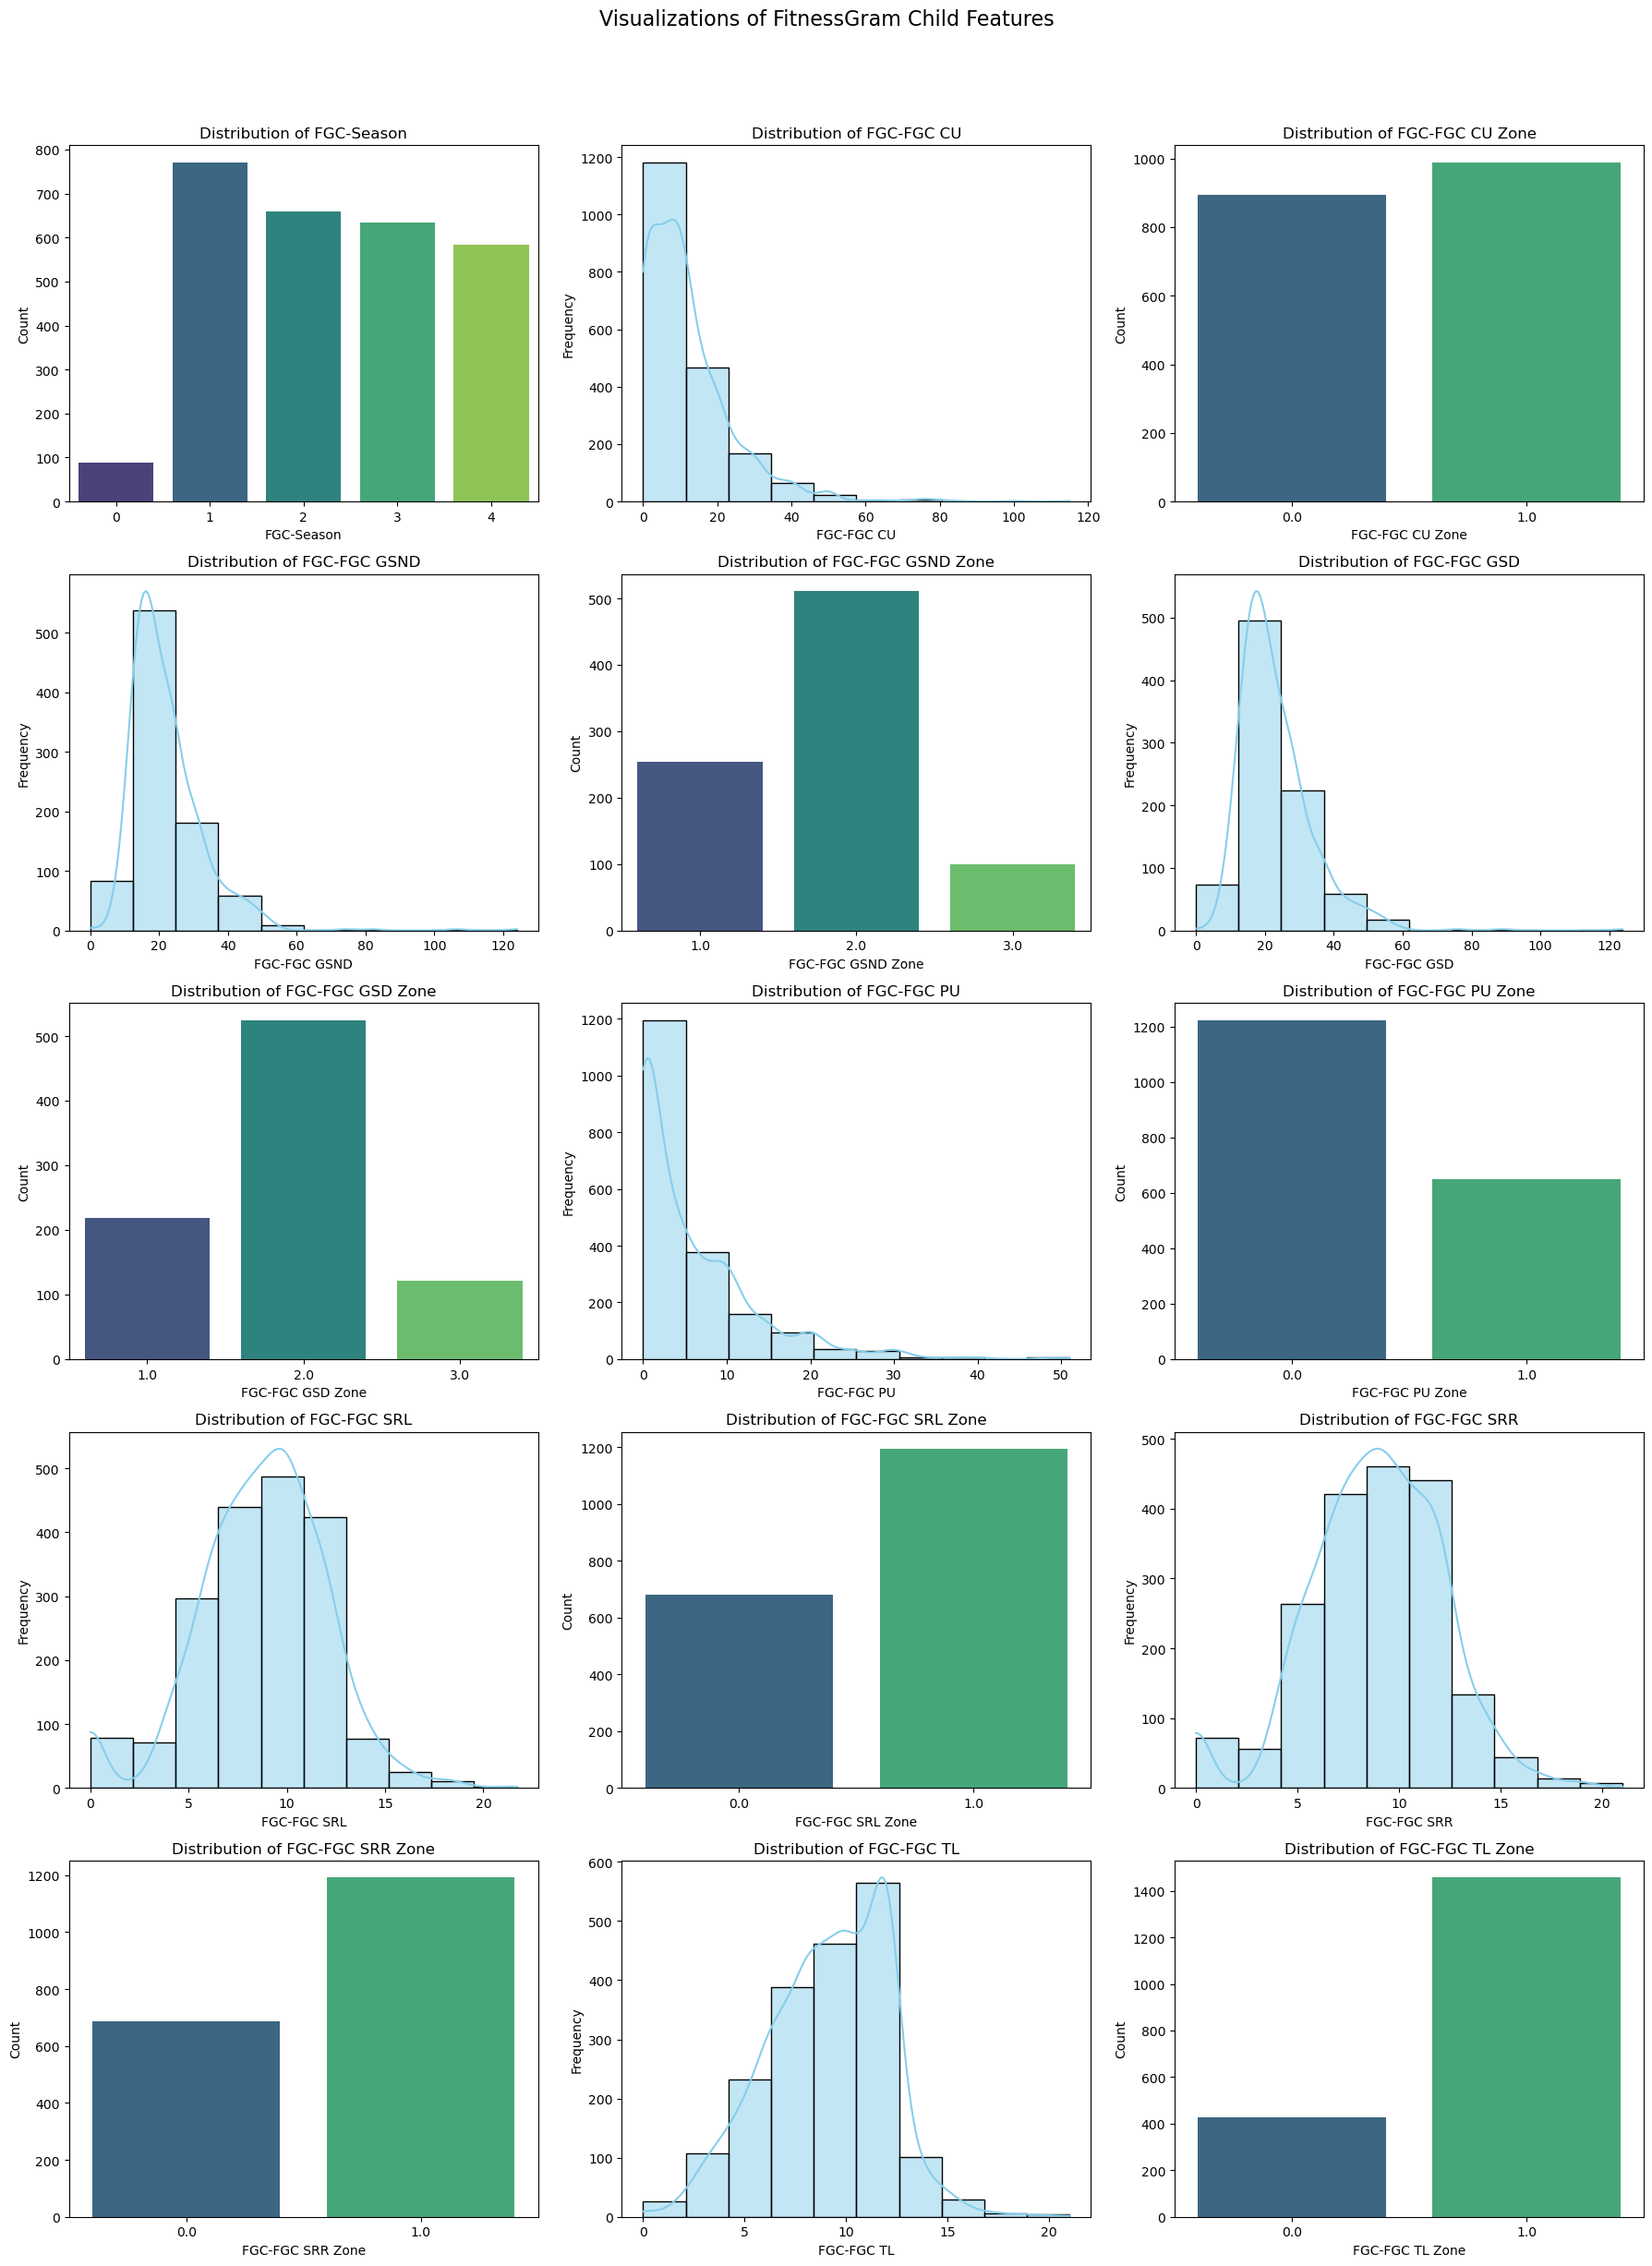

In [93]:
fitnessGramChild_features = {
    'FGC-Season': 'categorical',                  # Categorical string
    'FGC-FGC_CU': 'numerical',                    # Integer
    'FGC-FGC_CU_Zone': 'categorical',             # Categorical integer
    'FGC-FGC_GSND': 'numerical',                  # Float
    'FGC-FGC_GSND_Zone': 'categorical',           # Categorical integer
    'FGC-FGC_GSD': 'numerical',                   # Float
    'FGC-FGC_GSD_Zone': 'categorical',            # Categorical integer
    'FGC-FGC_PU': 'numerical',                    # Integer
    'FGC-FGC_PU_Zone': 'categorical',             # Categorical integer
    'FGC-FGC_SRL': 'numerical',                   # Float
    'FGC-FGC_SRL_Zone': 'categorical',            # Categorical integer
    'FGC-FGC_SRR': 'numerical',                   # Float
    'FGC-FGC_SRR_Zone': 'categorical',            # Categorical integer
    'FGC-FGC_TL': 'numerical',                    # Integer
    'FGC-FGC_TL_Zone': 'categorical'              # Categorical integer
}

plot_demographic_features(train_data, fitnessGramChild_features, 'FitnessGram Child')

### 8. Bio-electric Impedance Analysis

In [40]:
print(f"Samples for Instrument: {unique_instruments[6]}")
display(data_dictionary[data_dictionary['Instrument'] == unique_instruments[6]])

Samples for Instrument: Bio-electric Impedance Analysis


,Instrument,Field,Description,Type,Values,Value Labels
33,Bio-electric Impedance Analysis,BIA-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
34,Bio-electric Impedance Analysis,BIA-BIA_Activity_Level_num,Activity Level,categorical int,"1,2,3,4,5","1=Very Light, 2=Light, 3=Moderate, 4=Heavy, 5=..."
35,Bio-electric Impedance Analysis,BIA-BIA_BMC,Bone Mineral Content,float,NaN,NaN
36,Bio-electric Impedance Analysis,BIA-BIA_BMI,Body Mass Index,float,NaN,NaN
37,Bio-electric Impedance Analysis,BIA-BIA_BMR,Basal Metabolic Rate,float,NaN,NaN
38,Bio-electric Impedance Analysis,BIA-BIA_DEE,Daily Energy Expenditure,float,NaN,NaN
39,Bio-electric Impedance Analysis,BIA-BIA_ECW,Extracellular Water,float,NaN,NaN
40,Bio-electric Impedance Analysis,BIA-BIA_FFM,Fat Free Mass,float,NaN,NaN
41,Bio-electric Impedance Analysis,BIA-BIA_FFMI,Fat Free Mass Index,float,NaN,NaN
42,Bio-electric Impedance Analysis,BIA-BIA_FMI,Fat Mass Index,float,NaN,NaN


c:\Users\Hp\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\Hp\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\Hp\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\Hp\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\Hp\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version

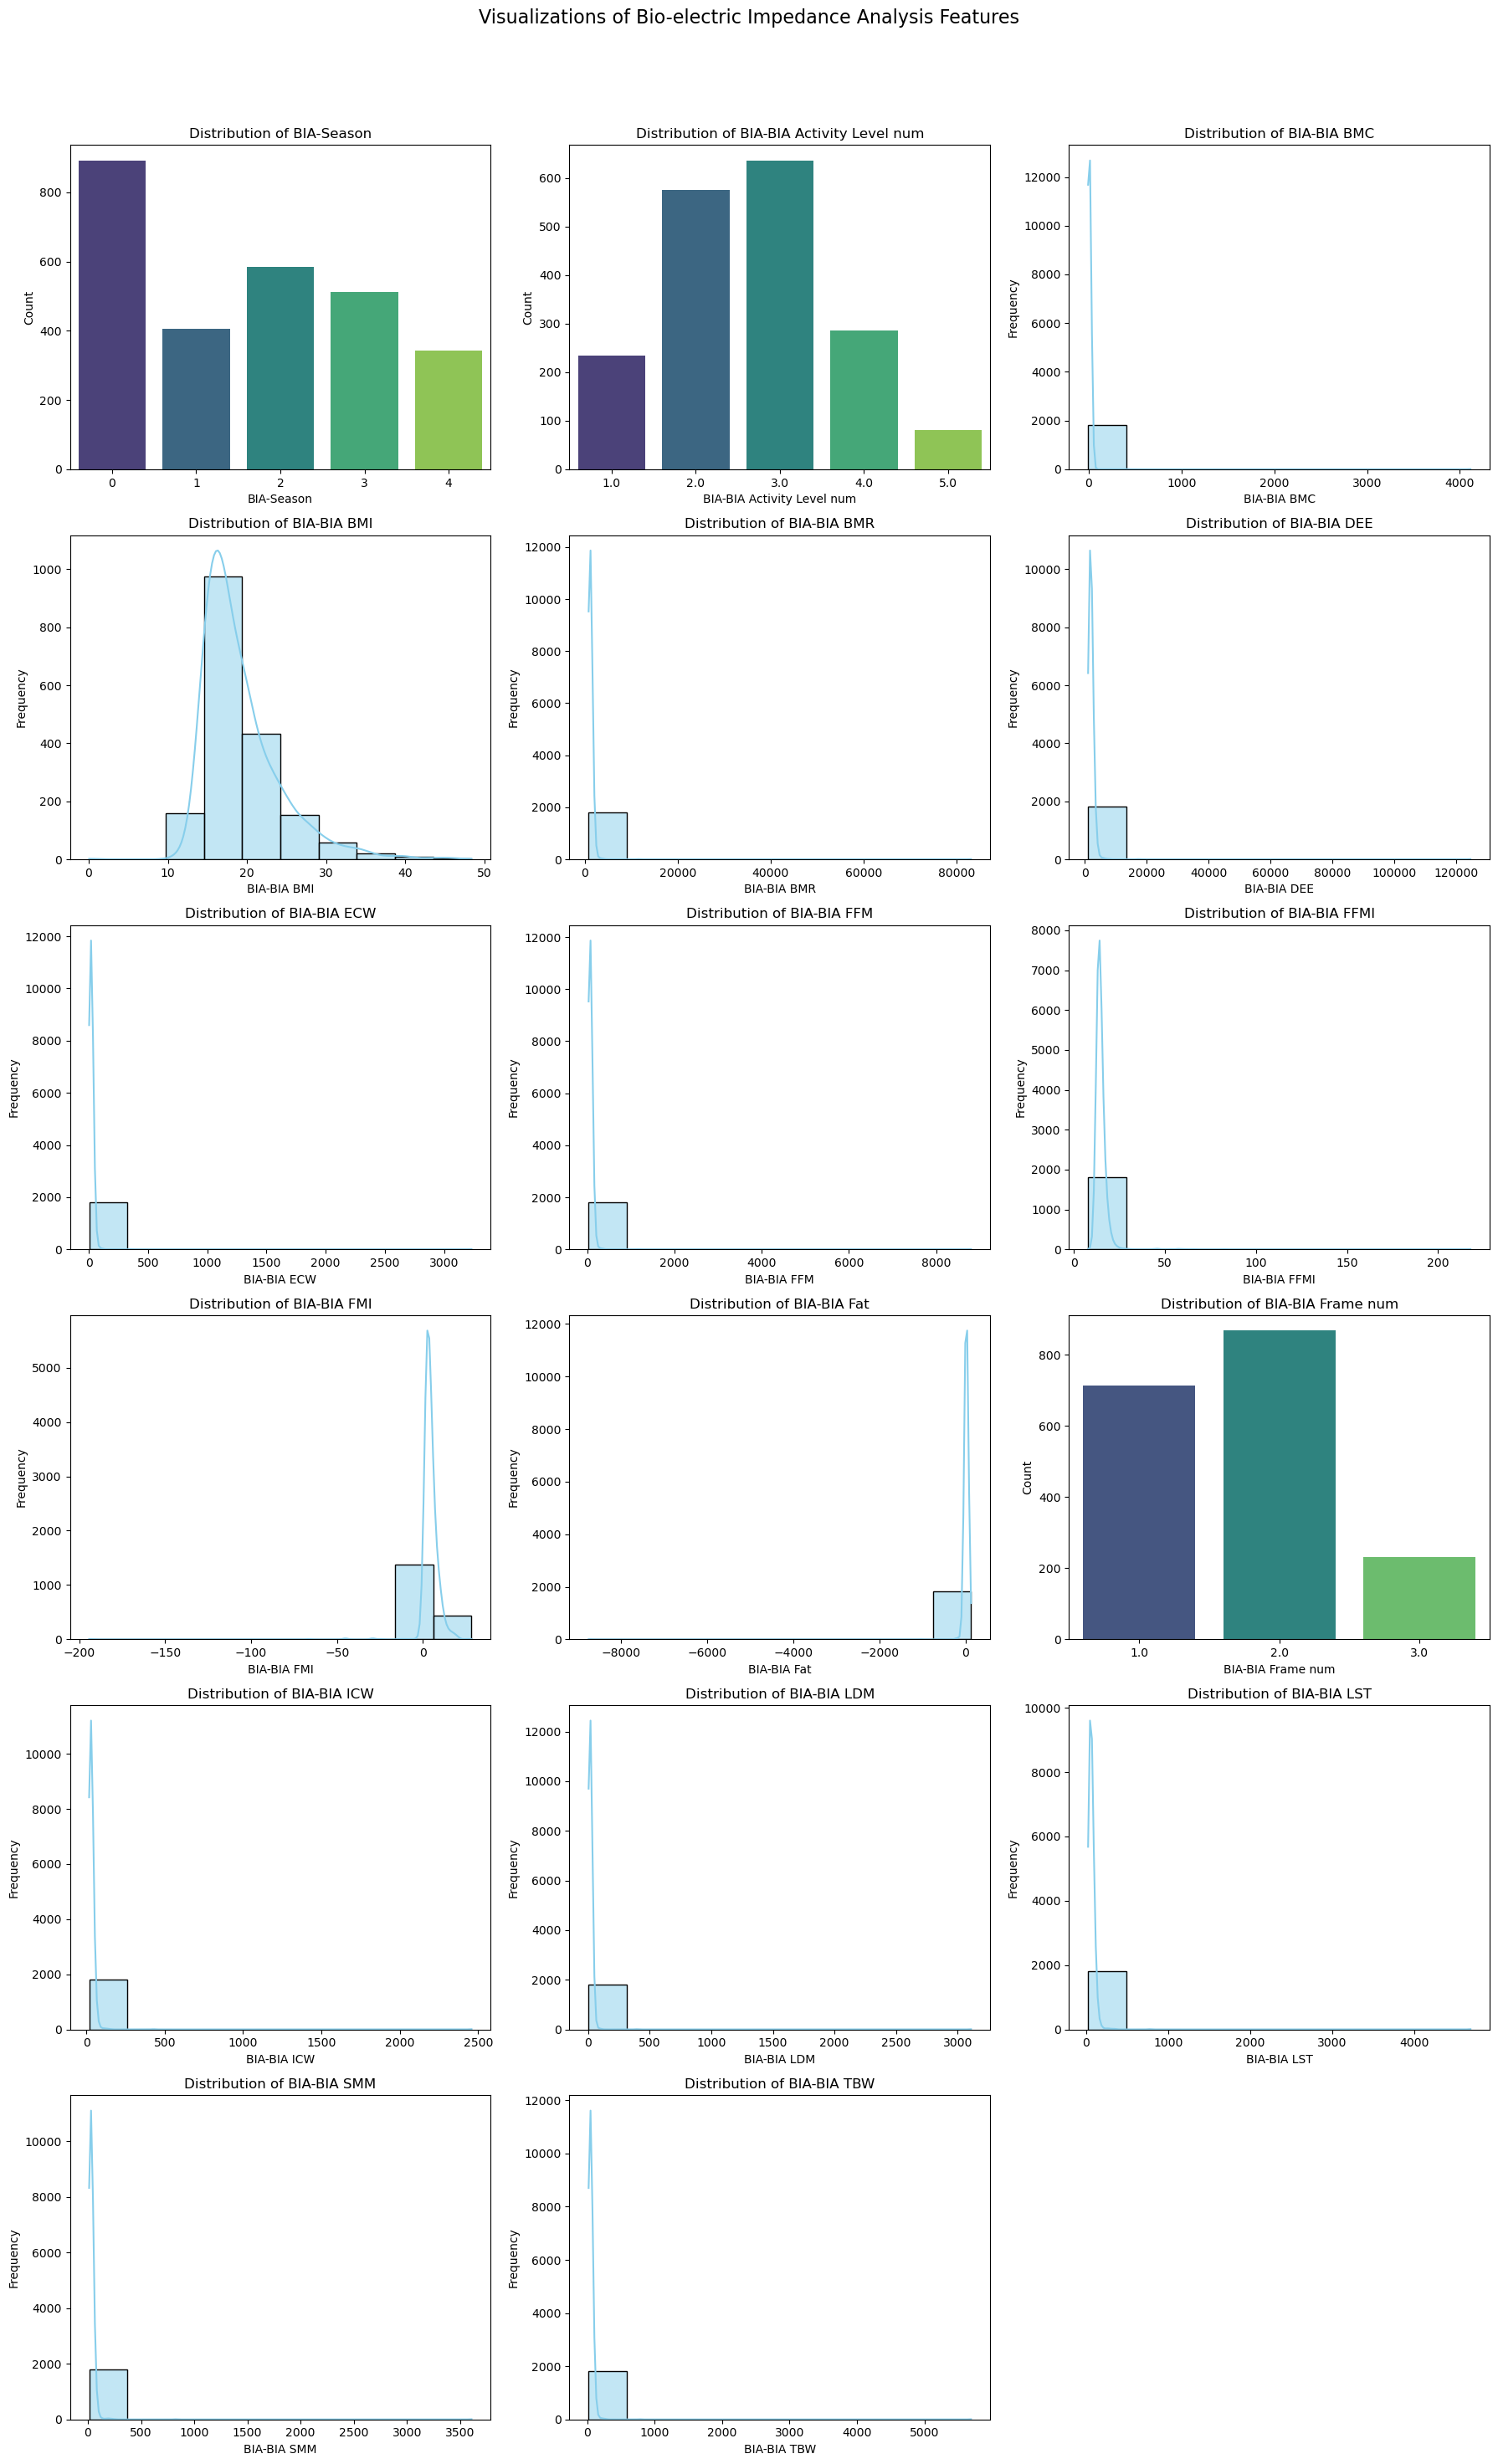

In [94]:
bioElectricImpedanceAnalysis_features = {
    'BIA-Season': 'categorical',                   # Categorical string
    'BIA-BIA_Activity_Level_num': 'categorical',   # Categorical integer
    'BIA-BIA_BMC': 'numerical',                    # Float
    'BIA-BIA_BMI': 'numerical',                    # Float
    'BIA-BIA_BMR': 'numerical',                    # Float
    'BIA-BIA_DEE': 'numerical',                    # Float
    'BIA-BIA_ECW': 'numerical',                    # Float
    'BIA-BIA_FFM': 'numerical',                    # Float
    'BIA-BIA_FFMI': 'numerical',                   # Float
    'BIA-BIA_FMI': 'numerical',                    # Float
    'BIA-BIA_Fat': 'numerical',                    # Float
    'BIA-BIA_Frame_num': 'categorical',            # Categorical integer
    'BIA-BIA_ICW': 'numerical',                    # Float
    'BIA-BIA_LDM': 'numerical',                    # Float
    'BIA-BIA_LST': 'numerical',                    # Float
    'BIA-BIA_SMM': 'numerical',                    # Float
    'BIA-BIA_TBW': 'numerical'                     # Float
}

plot_demographic_features(train_data, bioElectricImpedanceAnalysis_features, 'Bio-electric Impedance Analysis')

### 9. Physical Activity Questionnaire

In [36]:
print(f"Samples for Instrument: {unique_instruments[7]} | {unique_instruments[8]}")
display(data_dictionary[(data_dictionary['Instrument'] == unique_instruments[7]) | (data_dictionary['Instrument'] == unique_instruments[8])])

Samples for Instrument: Physical Activity Questionnaire (Adolescents) | Physical Activity Questionnaire (Children)


,Instrument,Field,Description,Type,Values,Value Labels
50,Physical Activity Questionnaire (Adolescents),PAQ_A-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
51,Physical Activity Questionnaire (Adolescents),PAQ_A-PAQ_A_Total,Activity Summary Score (Adolescents),float,NaN,NaN
52,Physical Activity Questionnaire (Children),PAQ_C-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
53,Physical Activity Questionnaire (Children),PAQ_C-PAQ_C_Total,Activity Summary Score (Children),float,NaN,NaN


c:\Users\Hp\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\Hp\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



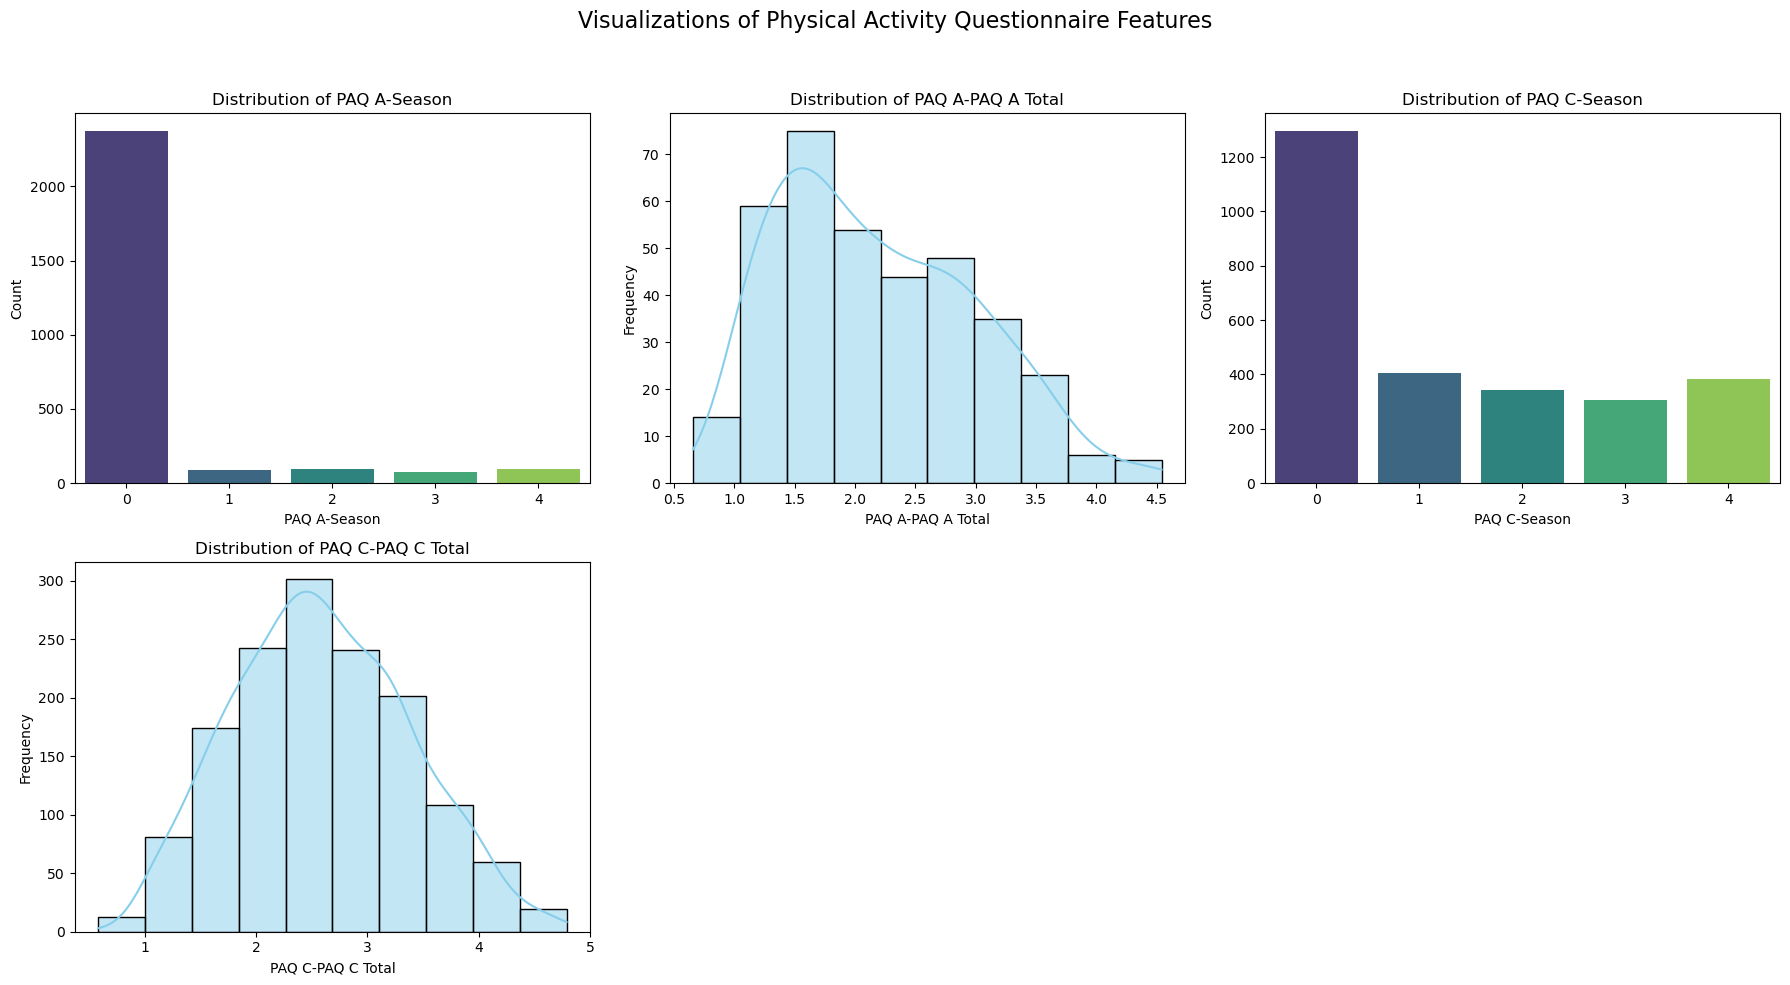

In [95]:
physicalActivityQuestionnaire_features = {
    'PAQ_A-Season': 'categorical',     # Categorical string
    'PAQ_A-PAQ_A_Total': 'numerical',  # Float
    'PAQ_C-Season': 'categorical',     # Categorical string
    'PAQ_C-PAQ_C_Total': 'numerical'   # Float
}

plot_demographic_features(train_data, physicalActivityQuestionnaire_features, 'Physical Activity Questionnaire')

### 10. Sleep Disturbance Scale

In [37]:
print(f"Samples for Instrument: {unique_instruments[10]}")
display(data_dictionary[data_dictionary['Instrument'] == unique_instruments[10]])

Samples for Instrument: Sleep Disturbance Scale


,Instrument,Field,Description,Type,Values,Value Labels
76,Sleep Disturbance Scale,SDS-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
77,Sleep Disturbance Scale,SDS-SDS_Total_Raw,Total Raw Score,int,NaN,NaN
78,Sleep Disturbance Scale,SDS-SDS_Total_T,Total T-Score,int,NaN,NaN


c:\Users\Hp\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\Hp\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



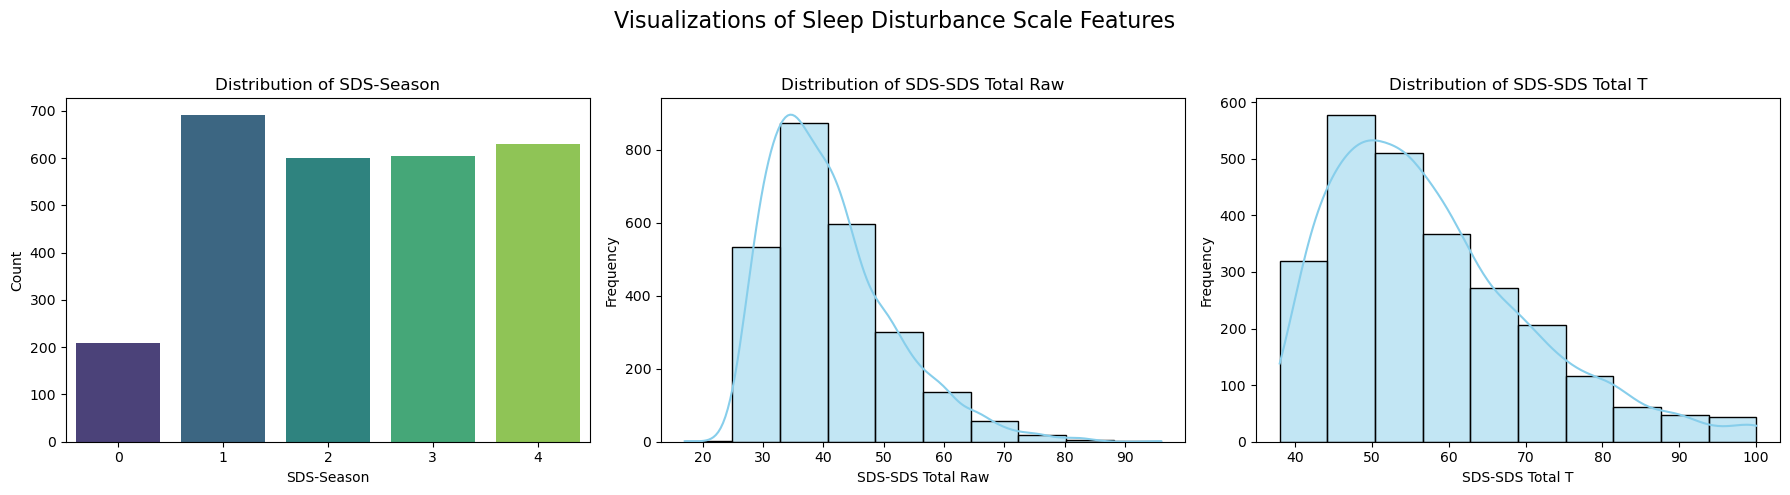

In [96]:
sleepDisturbanceScale_features = {
    'SDS-Season': 'categorical',          # Categorical string
    'SDS-SDS_Total_Raw': 'numerical',     # Integer
    'SDS-SDS_Total_T': 'numerical'        # Integer
}

plot_demographic_features(train_data,sleepDisturbanceScale_features, 'Sleep Disturbance Scale')

## 3. Correlations

Given the large number of available features, I decided to perform feature selection to assess its impact on the model. Here, I selected features with the strongest correlation to the PCIAT total score, discarding those with weaker correlations.

In [54]:
# Selecting only numeric columns for correlation
numeric_data = train_data.select_dtypes(include=['float64', 'int64'])
# Calculate correlation with PCIAT-PCIAT_Total
corr = numeric_data.corr()['PCIAT-PCIAT_Total'].sort_values(ascending=False)
corr = pd.DataFrame(corr)
corr.style.background_gradient(cmap='YlOrRd')

,PCIAT-PCIAT_Total
PCIAT-PCIAT_Total,1.000000
sii,0.899681
Physical-Height,0.420765
Basic_Demos-Age,0.409559
PreInt_EduHx-computerinternet_hoursday,0.374124
Physical-Weight,0.353048
Physical-Waist_Circumference,0.327013
FGC-FGC_CU,0.287494
BIA-BIA_BMI,0.248060
Physical-BMI,0.240858


In [55]:
selection = corr[(corr['PCIAT-PCIAT_Total']>.1) | (corr['PCIAT-PCIAT_Total']<-.1)]
selection = [val for val in selection.index]
# Remove Specific Features
selection.remove('PCIAT-PCIAT_Total')
selection.remove('sii')
selection.remove('Physical-BMI')
selection.remove('SDS-SDS_Total_Raw')

In [56]:
selection

['Physical-Height',
 'Basic_Demos-Age',
 'PreInt_EduHx-computerinternet_hoursday',
 'Physical-Weight',
 'Physical-Waist_Circumference',
 'FGC-FGC_CU',
 'BIA-BIA_BMI',
 'SDS-SDS_Total_T',
 'PAQ_A-Season',
 'FGC-FGC_PU',
 'BIA-BIA_Frame_num',
 'FGC-FGC_GSD',
 'Physical-Systolic_BP',
 'FGC-FGC_GSND',
 'FGC-FGC_TL',
 'PAQ_C-Season',
 'BIA-BIA_FFMI',
 'FGC-FGC_SRR_Zone',
 'FGC-FGC_SRL_Zone']

## 4. Missing Values

In [57]:
null = train_data.isna().sum().sort_values(ascending = False).head(46)
null = pd.DataFrame(null)
null = null.rename(columns= {0:'Missing'})
null.style.background_gradient(cmap='YlOrRd')

,Missing
PAQ_A-PAQ_A_Total,2373
Physical-Waist_Circumference,2253
Fitness_Endurance-Time_Sec,2008
Fitness_Endurance-Time_Mins,2008
Fitness_Endurance-Max_Stage,2005
FGC-FGC_GSD_Zone,1872
FGC-FGC_GSND_Zone,1872
FGC-FGC_GSD,1865
FGC-FGC_GSND,1864
PAQ_C-PAQ_C_Total,1296


In [58]:
half_missing = [val for val in train_data.columns[train_data.isnull().sum()>len(train_data)/2]]
half_missing

['Physical-Waist_Circumference',
 'Fitness_Endurance-Max_Stage',
 'Fitness_Endurance-Time_Mins',
 'Fitness_Endurance-Time_Sec',
 'FGC-FGC_GSND',
 'FGC-FGC_GSND_Zone',
 'FGC-FGC_GSD',
 'FGC-FGC_GSD_Zone',
 'PAQ_A-PAQ_A_Total']

In [59]:
selection = [i for i in selection if i not in half_missing]
selection

['Physical-Height',
 'Basic_Demos-Age',
 'PreInt_EduHx-computerinternet_hoursday',
 'Physical-Weight',
 'FGC-FGC_CU',
 'BIA-BIA_BMI',
 'SDS-SDS_Total_T',
 'PAQ_A-Season',
 'FGC-FGC_PU',
 'BIA-BIA_Frame_num',
 'Physical-Systolic_BP',
 'FGC-FGC_TL',
 'PAQ_C-Season',
 'BIA-BIA_FFMI',
 'FGC-FGC_SRR_Zone',
 'FGC-FGC_SRL_Zone']

In [98]:
train_data[selection]

,Physical-Height,Basic_Demos-Age,PreInt_EduHx-computerinternet_hoursday,Physical-Weight,FGC-FGC_CU,BIA-BIA_BMI,SDS-SDS_Total_T,PAQ_A-Season,FGC-FGC_PU,BIA-BIA_Frame_num,Physical-Systolic_BP,FGC-FGC_TL,PAQ_C-Season,BIA-BIA_FFMI,FGC-FGC_SRR_Zone,FGC-FGC_SRL_Zone
0,46.0,5,3.0,50.8,0.0,16.8792,NaN,0,0.0,1.0,NaN,6.0,0,13.8177,0.0,0.0
1,48.0,9,0.0,46.0,3.0,14.0371,64.0,0,5.0,1.0,122.0,3.0,3,12.8254,1.0,1.0
2,56.5,10,2.0,75.6,20.0,NaN,54.0,0,7.0,NaN,117.0,5.0,2,NaN,1.0,1.0
3,56.0,9,0.0,81.6,18.0,18.2943,45.0,0,5.0,2.0,117.0,7.0,4,14.0740,0.0,0.0
5,59.5,13,0.0,112.2,12.0,30.1865,56.0,0,6.0,2.0,102.0,8.0,1,16.6877,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3953,52.5,8,2.0,67.2,0.0,17.1417,58.0,0,0.0,1.0,112.0,12.0,3,13.4004,1.0,1.0
3954,48.5,7,0.0,46.6,0.0,13.6457,67.0,0,0.0,1.0,105.0,4.5,0,13.2315,0.0,0.0
3955,59.5,13,1.0,82.4,16.0,16.3642,50.0,0,10.0,1.0,104.0,12.0,4,14.0629,1.0,1.0
3957,60.0,11,0.0,109.8,15.0,21.4438,77.0,0,0.0,2.0,116.0,14.0,4,14.8043,1.0,1.0


In [100]:
describe = train_data[selection].describe().T
describe = describe[['min','max', 'count']].sort_index()

# Calculate the percentage of missing values for each feature
missing_percentage = train_data[selection].isnull().mean() * 100
missing_info = describe.copy()
missing_info['missing_percentage'] = missing_percentage
missing_info = missing_info.sort_index()

# Display the result with the background gradient
missing_info.style.background_gradient(cmap='YlOrRd')


,min,max,count,missing_percentage
BIA-BIA_BMI,0.048267,48.375400,1813.000000,33.735380
BIA-BIA_FFMI,7.864850,217.771000,1813.000000,33.735380
BIA-BIA_Frame_num,1.000000,3.000000,1813.000000,33.735380
Basic_Demos-Age,5.000000,22.000000,2736.000000,0.000000
FGC-FGC_CU,0.000000,115.000000,1919.000000,29.861111
FGC-FGC_PU,0.000000,51.000000,1909.000000,30.226608
FGC-FGC_SRL_Zone,0.000000,1.000000,1877.000000,31.396199
FGC-FGC_SRR_Zone,0.000000,1.000000,1879.000000,31.323099
FGC-FGC_TL,0.000000,21.000000,1919.000000,29.861111
PAQ_A-Season,0.000000,4.000000,2736.000000,0.000000


In [101]:
from sklearn.impute import SimpleImputer

# For features with less than 10% missing values
# Define threshold for missing values
threshold = 10

# Select columns with < 10% missing values
low_missing_cols = missing_info[missing_info['missing_percentage'] < threshold].index
high_missing_cols = missing_info[missing_info['missing_percentage'] >= threshold].index

# Impute numerical features with mean or median
numerical_imputer = SimpleImputer(strategy='mean')  # or 'median' based on distribution
train_data[low_missing_cols] = numerical_imputer.fit_transform(train_data[low_missing_cols])

# Impute categorical features with mode
categorical_imputer = SimpleImputer(strategy='most_frequent')
train_data[low_missing_cols] = categorical_imputer.fit_transform(train_data[low_missing_cols])

# For features with more than 10% missing values
for col in high_missing_cols:
    # Create an indicator column
    train_data[f'{col}_missing'] = train_data[col].isnull().astype(int)
    # Impute missing values in the original column
    if train_data[col].dtype in ['float64', 'int64']:  # Numerical
        train_data[col] = numerical_imputer.fit_transform(train_data[[col]])
    else:  # Categorical
        train_data[col] = categorical_imputer.fit_transform(train_data[[col]])


In [102]:
train_data[selection].describe().T

,count,mean,std,min,25%,50%,75%,max
Physical-Height,2736.0,55.897051,7.110994,36.000000,50.500000,55.897051,61.000000,78.5000
Basic_Demos-Age,2736.0,10.238670,3.427982,5.000000,8.000000,10.000000,12.000000,22.0000
PreInt_EduHx-computerinternet_hoursday,2736.0,1.015072,1.064535,0.000000,0.000000,1.000000,2.000000,3.0000
Physical-Weight,2736.0,87.839592,42.033187,0.000000,58.200000,79.200000,108.600000,315.0000
FGC-FGC_CU,2736.0,11.912976,10.032242,0.000000,6.000000,11.912976,12.000000,115.0000
BIA-BIA_BMI,2736.0,19.232347,4.006205,0.048267,16.783775,19.232347,19.332125,48.3754
SDS-SDS_Total_T,2736.0,57.647525,12.529604,38.000000,49.000000,56.000000,63.000000,100.0000
PAQ_A-Season,2736.0,0.332602,0.945562,0.000000,0.000000,0.000000,0.000000,4.0000
FGC-FGC_PU,2736.0,5.782609,6.215061,0.000000,1.000000,5.782609,6.000000,51.0000
BIA-BIA_Frame_num,2736.0,1.733591,0.546327,1.000000,1.000000,1.733591,2.000000,3.0000


In [103]:
describe = train_data[selection].describe().T
describe = describe[['min','max']].sort_index()
describe.style.background_gradient(cmap='YlOrRd')

,min,max
BIA-BIA_BMI,0.048267,48.375400
BIA-BIA_FFMI,7.864850,217.771000
BIA-BIA_Frame_num,1.000000,3.000000
Basic_Demos-Age,5.000000,22.000000
FGC-FGC_CU,0.000000,115.000000
FGC-FGC_PU,0.000000,51.000000
FGC-FGC_SRL_Zone,0.000000,1.000000
FGC-FGC_SRR_Zone,0.000000,1.000000
FGC-FGC_TL,0.000000,21.000000
PAQ_A-Season,0.000000,4.000000


In [104]:
scaler = MinMaxScaler()
train_data_scaled = pd.DataFrame(scaler.fit_transform(train_data[selection]),
                                  columns=selection,
                                  index=train_data.index)

In [105]:
# Get descriptive statistics for the scaled data
scaled_describe = train_data_scaled.describe().T[['count', 'min', 'max']].sort_index()

# Display the result
scaled_describe.style.background_gradient(cmap='YlOrRd')

,count,min,max
BIA-BIA_BMI,2736.000000,0.000000,1.000000
BIA-BIA_FFMI,2736.000000,0.000000,1.000000
BIA-BIA_Frame_num,2736.000000,0.000000,1.000000
Basic_Demos-Age,2736.000000,0.000000,1.000000
FGC-FGC_CU,2736.000000,0.000000,1.000000
FGC-FGC_PU,2736.000000,0.000000,1.000000
FGC-FGC_SRL_Zone,2736.000000,0.000000,1.000000
FGC-FGC_SRR_Zone,2736.000000,0.000000,1.000000
FGC-FGC_TL,2736.000000,0.000000,1.000000
PAQ_A-Season,2736.000000,0.000000,1.000000


In [63]:
X = train_data[selection]
test = test_data[selection]
y = train_data.sii

In [65]:
X

,Physical-Height,Basic_Demos-Age,PreInt_EduHx-computerinternet_hoursday,Physical-Weight,FGC-FGC_CU,BIA-BIA_BMI,SDS-SDS_Total_T,PAQ_A-Season,FGC-FGC_PU,BIA-BIA_Frame_num,Physical-Systolic_BP,FGC-FGC_TL,PAQ_C-Season,BIA-BIA_FFMI,FGC-FGC_SRR_Zone,FGC-FGC_SRL_Zone
0,46.0,5,3.0,50.8,0.0,16.8792,NaN,0,0.0,1.0,NaN,6.0,0,13.8177,0.0,0.0
1,48.0,9,0.0,46.0,3.0,14.0371,64.0,0,5.0,1.0,122.0,3.0,3,12.8254,1.0,1.0
2,56.5,10,2.0,75.6,20.0,NaN,54.0,0,7.0,NaN,117.0,5.0,2,NaN,1.0,1.0
3,56.0,9,0.0,81.6,18.0,18.2943,45.0,0,5.0,2.0,117.0,7.0,4,14.0740,0.0,0.0
5,59.5,13,0.0,112.2,12.0,30.1865,56.0,0,6.0,2.0,102.0,8.0,1,16.6877,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3953,52.5,8,2.0,67.2,0.0,17.1417,58.0,0,0.0,1.0,112.0,12.0,3,13.4004,1.0,1.0
3954,48.5,7,0.0,46.6,0.0,13.6457,67.0,0,0.0,1.0,105.0,4.5,0,13.2315,0.0,0.0
3955,59.5,13,1.0,82.4,16.0,16.3642,50.0,0,10.0,1.0,104.0,12.0,4,14.0629,1.0,1.0
3957,60.0,11,0.0,109.8,15.0,21.4438,77.0,0,0.0,2.0,116.0,14.0,4,14.8043,1.0,1.0


## Selected Features